In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import pydicom
import os
from tqdm import tqdm

In [23]:
DATA_DIR = '/Users/admin/Working/Data/vinbigdata-chest-xray'
TRAIN_CSV_PATH = os.path.join(DATA_DIR, 'train.csv')
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR, 'train') # Thư mục chứa ảnh DICOM

In [24]:
# Kiểm tra dataset
df_train = pd.read_csv(TRAIN_CSV_PATH)

print("Thông tin của train.csv:")
df_train.info()

print("\n\n5 dòng đầu tiên của train.csv:")
print(df_train.head())

print(f"\n\nSố lượng dòng (annotations): {len(df_train)}")
print(f"Số lượng image_id duy nhất: {df_train['image_id'].nunique()}")
print(f"Các class_name duy nhất: {df_train['class_name'].unique()}")
print(f"Số lượng class_name duy nhất (bao gồm 'No finding'): {df_train['class_name'].nunique()}")

Thông tin của train.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67914 entries, 0 to 67913
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_id    67914 non-null  object 
 1   class_name  67914 non-null  object 
 2   class_id    67914 non-null  int64  
 3   rad_id      67914 non-null  object 
 4   x_min       36096 non-null  float64
 5   y_min       36096 non-null  float64
 6   x_max       36096 non-null  float64
 7   y_max       36096 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 4.1+ MB


5 dòng đầu tiên của train.csv:
                           image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement   

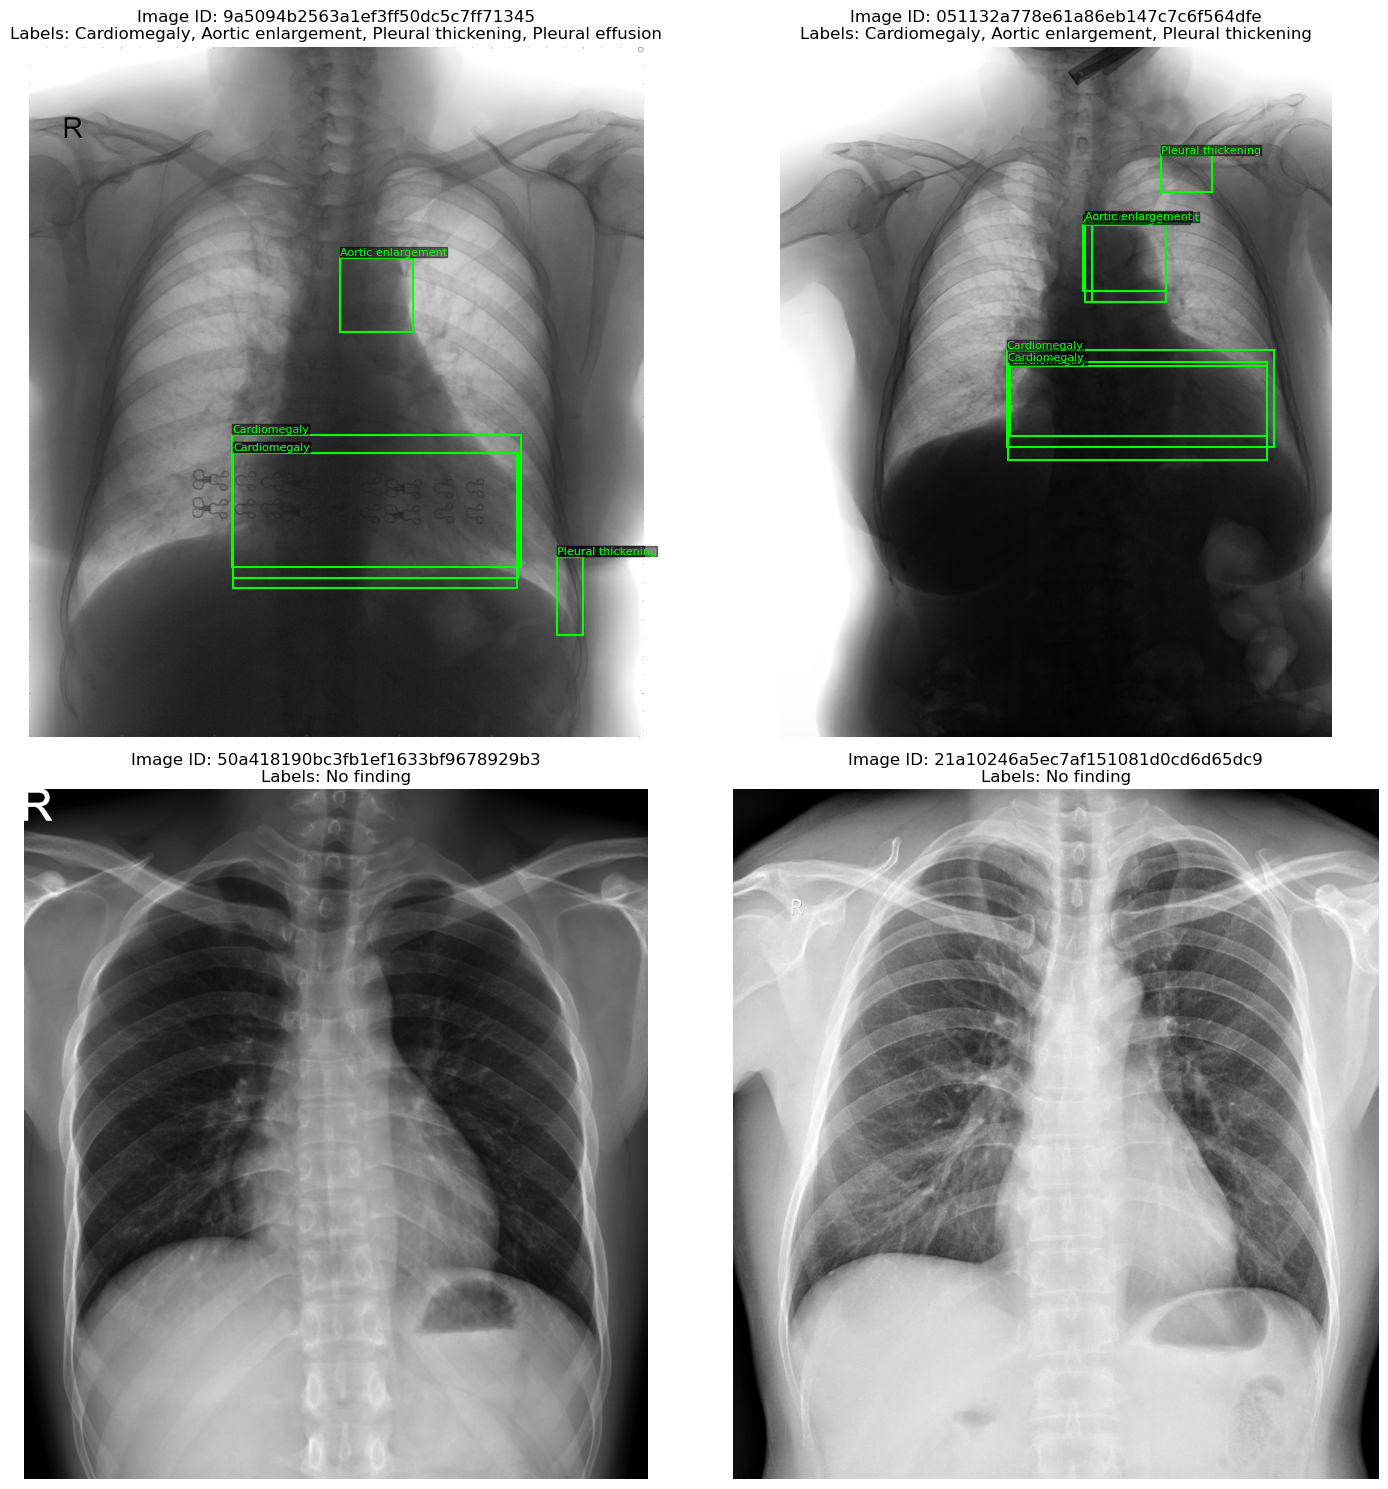

In [26]:
# Trực quan hóa ảnh mẫu một số sample image
def display_image_with_annotations(image_id, df_annotations, image_dir, ax=None):
    """Hiển thị ảnh DICOM và các bounding box"""
    image_path = os.path.join(image_dir, f"{image_id}.dicom")
    try:
        dicom_data = pydicom.dcmread(image_path)
        image = dicom_data.pixel_array
    except FileNotFoundError:
        print(f"Không tìm thấy ảnh: {image_path}")
        if ax:
            ax.text(0.5, 0.5, 'Image not found', ha='center', va='center')
            ax.set_title(f"Image ID: {image_id} (Not Found)")
        return
    except Exception as e:
        print(f"Lỗi khi đọc ảnh {image_path}: {e}")
        if ax:
            ax.text(0.5, 0.5, 'Error loading image', ha='center', va='center')
            ax.set_title(f"Image ID: {image_id} (Error)")
        return

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    ax.imshow(image, cmap=plt.cm.gray)
    ax.set_title(f"Image ID: {image_id}")
    ax.axis('off')

    # Lấy các annotations cho ảnh này
    annotations = df_annotations[df_annotations['image_id'] == image_id]
    
    labels_on_image = []
    if not annotations.empty:
        for _, row in annotations.iterrows():
            class_name = row['class_name']
            labels_on_image.append(class_name)
            if class_name != "No finding": # Không vẽ box cho "No finding"
                x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']
                # Kiểm tra NaN (nếu có) cho tọa độ bbox
                if pd.notna(x_min) and pd.notna(y_min) and pd.notna(x_max) and pd.notna(y_max):
                    width = x_max - x_min
                    height = y_max - y_min
                    rect = patches.Rectangle((x_min, y_min), width, height,
                                             linewidth=1.5, edgecolor='lime', facecolor='none')
                    ax.add_patch(rect)
                    ax.text(x_min, y_min - 10, class_name, color='lime', fontsize=8,
                            bbox=dict(facecolor='black', alpha=0.5, pad=0))
        ax.set_title(f"Image ID: {image_id}\nLabels: {', '.join(list(set(labels_on_image)))}")

# Chọn 2 images có annotation và 2 images không có annotation
sample_image_ids_with_findings = df_train[df_train['class_name'] != 'No finding']['image_id'].unique()[:2]
sample_image_ids_no_findings = df_train[df_train['class_name'] == 'No finding']['image_id'].unique()[:2]

if len(sample_image_ids_with_findings) > 0 and len(sample_image_ids_no_findings) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes = axes.ravel()

    if len(sample_image_ids_with_findings) > 0:
        display_image_with_annotations(sample_image_ids_with_findings[0], df_train, TRAIN_IMAGE_DIR, ax=axes[0])
    if len(sample_image_ids_with_findings) > 1:
        display_image_with_annotations(sample_image_ids_with_findings[1], df_train, TRAIN_IMAGE_DIR, ax=axes[1])
    
    if len(sample_image_ids_no_findings) > 0:
        display_image_with_annotations(sample_image_ids_no_findings[0], df_train, TRAIN_IMAGE_DIR, ax=axes[2])
    if len(sample_image_ids_no_findings) > 1:
        display_image_with_annotations(sample_image_ids_no_findings[1], df_train, TRAIN_IMAGE_DIR, ax=axes[3])

    plt.tight_layout()
    plt.show()
else:
    print("Không đủ ảnh mẫu để hiển thị (cần ít nhất 1 ảnh có finding và 1 ảnh không có finding).")

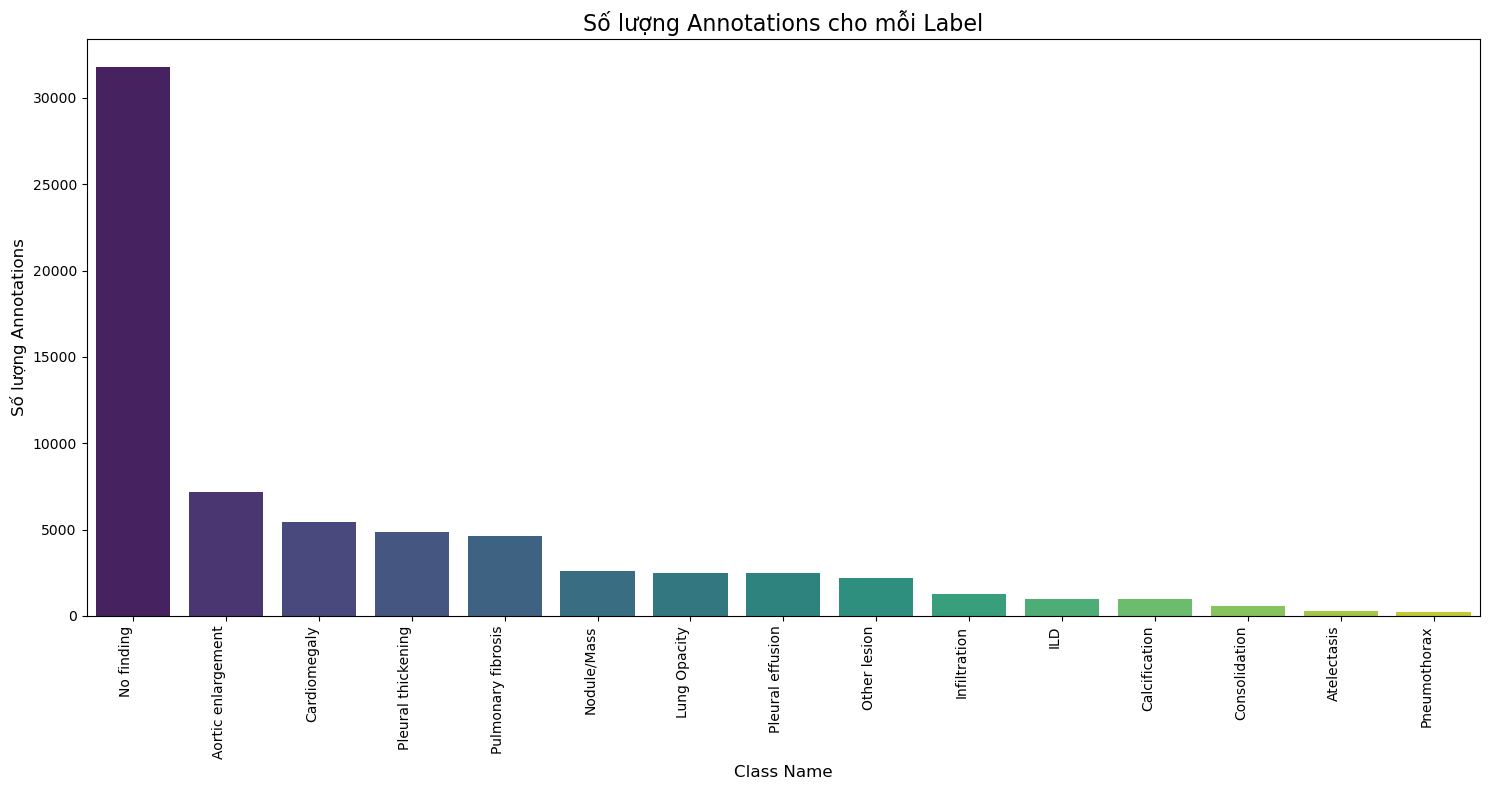


Số lượng annotations mỗi label:
class_name
No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: count, dtype: int64


In [27]:
# Thống kê số lượng theo label
label_counts = df_train['class_name'].value_counts()

plt.figure(figsize=(15, 8))
# Sửa đổi dòng này:
sns.barplot(x=label_counts.index, y=label_counts.values, 
            hue=label_counts.index, # Gán x cho hue
            palette="viridis", 
            legend=False) # Tắt legend nếu không cần thiết

plt.title('Số lượng Annotations cho mỗi Label', fontsize=16)
plt.xlabel('Class Name', fontsize=12)
plt.ylabel('Số lượng Annotations', fontsize=12)
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()

print("\nSố lượng annotations mỗi label:")
print(label_counts)

Đang tải thông tin kích thước ảnh từ cache: /Users/admin/Working/Data/vinbigdata-chest-xray/image_dimensions_cache.csv

Thông tin metadata ảnh (5 dòng đầu):
                           image_id  width  height  bits_allocated  \
0  50a418190bc3fb1ef1633bf9678929b3   2332    2580              16   
1  21a10246a5ec7af151081d0cd6d65dc9   2954    3159              16   
2  9a5094b2563a1ef3ff50dc5c7ff71345   2080    2336              16   
3  051132a778e61a86eb147c7c6f564dfe   2304    2880              16   
4  063319de25ce7edb9b1c6b8881290140   2540    3072              16   

  photometric_interpretation  
0                MONOCHROME2  
1                MONOCHROME2  
2                MONOCHROME1  
3                MONOCHROME1  
4                MONOCHROME2  

Số lượng ảnh có metadata: 15000
Số lượng ảnh bị thiếu metadata: 0


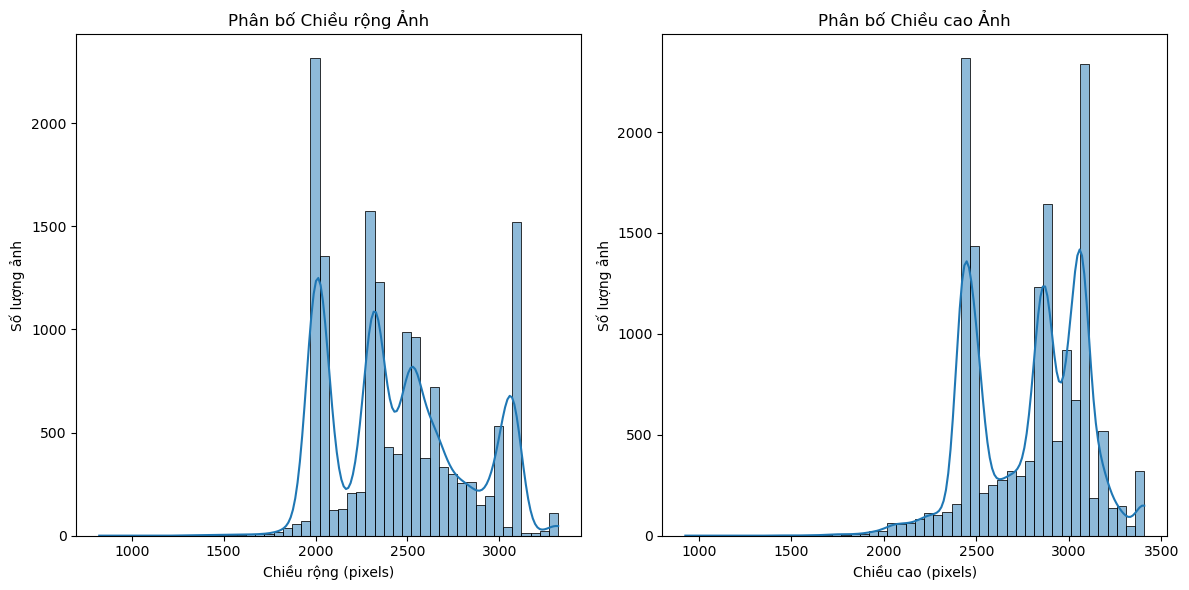

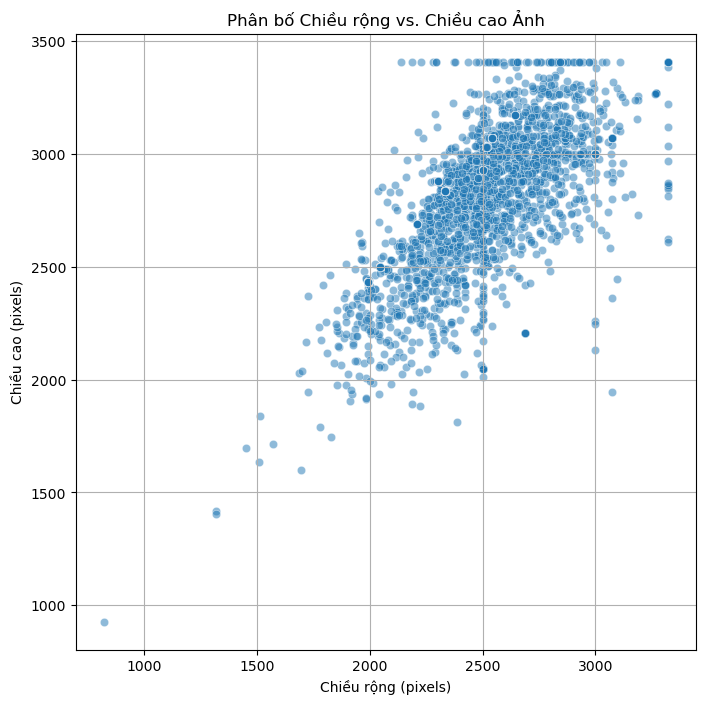


Các kích thước ảnh phổ biến:
      width  height  count
273    1994    2430   2201
5460   3072    3072   1474
1197   2304    2880   1294
380    2048    2500   1261
1395   2336    2836    864
3061   2540    3072    591
5371   3000    3000    438
3785   2642    3170    349
2880   2517    3028    317
2790   2504    2930    107


In [28]:
# Độ phân giải, số lượng ảnh mỗi label

# Lấy kích thước ảnh
# Chúng ta sẽ lưu trữ kích thước để không phải đọc lại file nhiều lần
image_dims_cache_file = os.path.join(DATA_DIR, 'image_dimensions_cache.csv')
if os.path.exists(image_dims_cache_file):
    print(f"Đang tải thông tin kích thước ảnh từ cache: {image_dims_cache_file}")
    df_image_meta = pd.read_csv(image_dims_cache_file)
else:
    print("Đang đọc kích thước ảnh từ file DICOM...")
    unique_image_ids = df_train['image_id'].unique()
    image_meta_data = []
    
    for image_id in tqdm(unique_image_ids, desc="Đọc metadata ảnh"):
        image_path = os.path.join(TRAIN_IMAGE_DIR, f"{image_id}.dicom")
        try:
            dicom_data = pydicom.dcmread(image_path, stop_before_pixels=True) # Chỉ đọc metadata
            image_meta_data.append({
                'image_id': image_id,
                'width': dicom_data.Columns,
                'height': dicom_data.Rows,
                'bits_allocated': dicom_data.BitsAllocated,
                'photometric_interpretation': dicom_data.PhotometricInterpretation
            })
        except FileNotFoundError:
            print(f"Cảnh báo: Không tìm thấy ảnh {image_path} khi lấy metadata.")
            image_meta_data.append({
                'image_id': image_id,
                'width': np.nan,
                'height': np.nan,
                'bits_allocated': np.nan,
                'photometric_interpretation': np.nan
            })
        except Exception as e:
            print(f"Lỗi khi đọc metadata cho {image_path}: {e}")
            image_meta_data.append({
                'image_id': image_id,
                'width': np.nan,
                'height': np.nan,
                'bits_allocated': np.nan,
                'photometric_interpretation': np.nan
            })

    df_image_meta = pd.DataFrame(image_meta_data)
    df_image_meta.to_csv(image_dims_cache_file, index=False)
    print(f"Lưu thông tin kích thước ảnh vào: {image_dims_cache_file}")

print("\nThông tin metadata ảnh (5 dòng đầu):")
print(df_image_meta.head())
print(f"\nSố lượng ảnh có metadata: {len(df_image_meta)}")
print(f"Số lượng ảnh bị thiếu metadata: {df_image_meta['width'].isna().sum()}")

# Bỏ qua các ảnh không đọc được metadata (nếu có)
df_image_meta_valid = df_image_meta.dropna(subset=['width', 'height'])
df_image_meta_valid['width'] = df_image_meta_valid['width'].astype(int)
df_image_meta_valid['height'] = df_image_meta_valid['height'].astype(int)


# Trực quan hóa phân bố độ phân giải chung
if not df_image_meta_valid.empty:
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df_image_meta_valid['width'], kde=True, bins=50)
    plt.title('Phân bố Chiều rộng Ảnh')
    plt.xlabel('Chiều rộng (pixels)')
    plt.ylabel('Số lượng ảnh')

    plt.subplot(1, 2, 2)
    sns.histplot(df_image_meta_valid['height'], kde=True, bins=50)
    plt.title('Phân bố Chiều cao Ảnh')
    plt.xlabel('Chiều cao (pixels)')
    plt.ylabel('Số lượng ảnh')
    plt.tight_layout()
    plt.show()

    # Scatter plot width vs height
    plt.figure(figsize=(8, 8))
    # Lấy mẫu nếu có quá nhiều điểm để vẽ
    sample_df = df_image_meta_valid.sample(n=min(5000, len(df_image_meta_valid)), random_state=42)
    sns.scatterplot(data=sample_df, x='width', y='height', alpha=0.5)
    plt.title('Phân bố Chiều rộng vs. Chiều cao Ảnh')
    plt.xlabel('Chiều rộng (pixels)')
    plt.ylabel('Chiều cao (pixels)')
    plt.grid(True)
    plt.show()

    print("\nCác kích thước ảnh phổ biến:")
    print(df_image_meta_valid.groupby(['width', 'height']).size().reset_index(name='count').sort_values('count', ascending=False).head(10))
else:
    print("Không có dữ liệu metadata hợp lệ để trực quan hóa độ phân giải.")




Số lượng ảnh DUY NHẤT cho mỗi label (kể cả 'No finding'):
class_name
No finding            10606
Aortic enlargement     3067
Cardiomegaly           2300
Pleural thickening     1981
Pulmonary fibrosis     1617
Lung Opacity           1322
Other lesion           1134
Pleural effusion       1032
Nodule/Mass             826
Infiltration            613
Calcification           452
ILD                     386
Consolidation           353
Atelectasis             186
Pneumothorax             96
Name: image_id, dtype: int64


/var/folders/hd/0xsd_q5j2nd1p2fgl1y8tngc0000gn/T/ipykernel_12053/2406356388.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_images_per_label.index, y=unique_images_per_label.values, palette="mako")


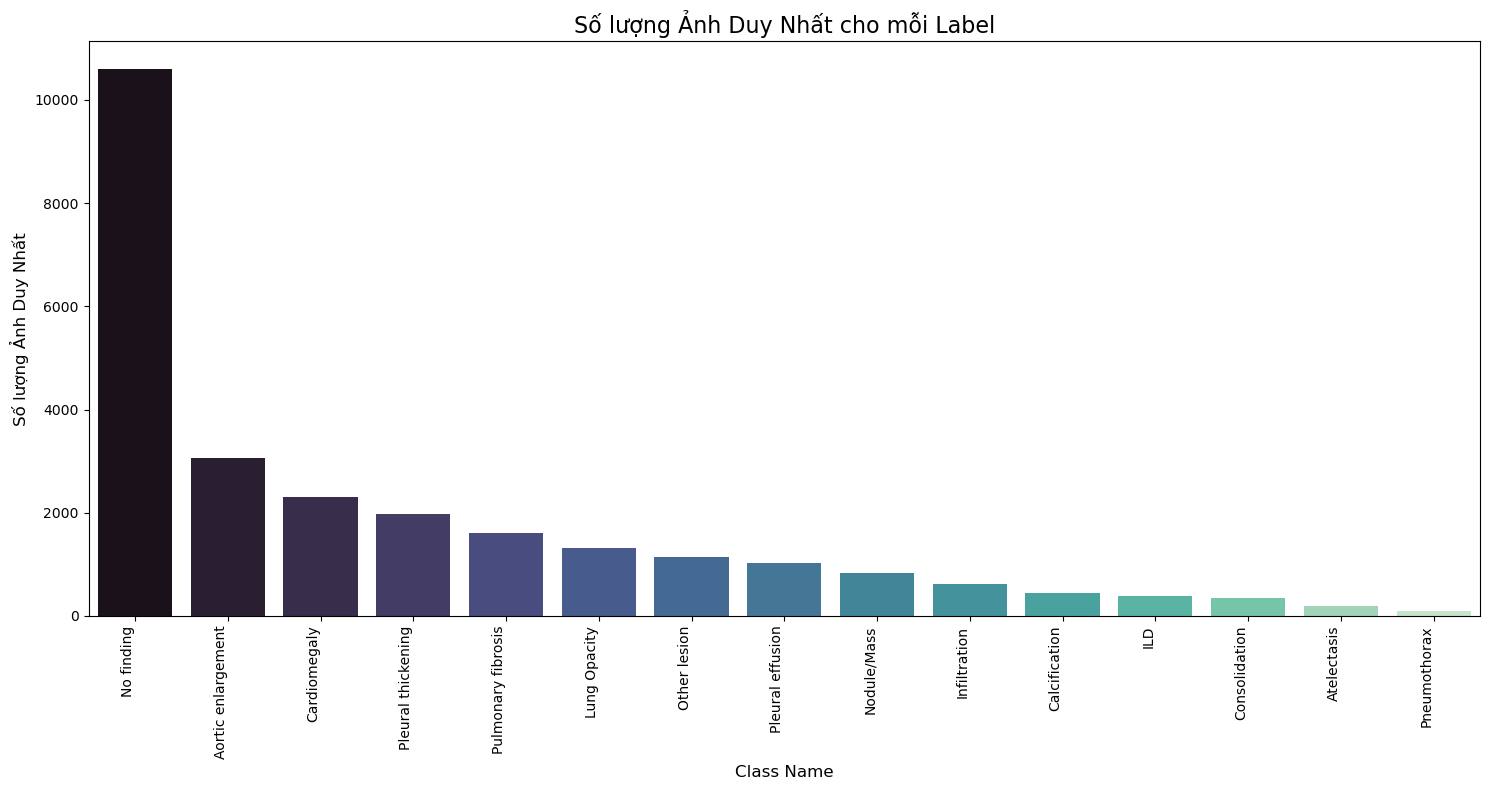

In [29]:
# Kết hợp df_train với df_image_meta_valid để lấy thông tin kích thước cho mỗi annotation
df_merged = pd.merge(df_train, df_image_meta_valid, on='image_id', how='left')

# Số lượng ảnh DUY NHẤT cho mỗi label
print("\nSố lượng ảnh DUY NHẤT cho mỗi label (kể cả 'No finding'):")
# Nhóm theo class_name, sau đó đếm số lượng image_id duy nhất trong mỗi nhóm
unique_images_per_label = df_merged.groupby('class_name')['image_id'].nunique().sort_values(ascending=False)
print(unique_images_per_label)

plt.figure(figsize=(15, 8))
sns.barplot(x=unique_images_per_label.index, y=unique_images_per_label.values, palette="mako")
plt.title('Số lượng Ảnh Duy Nhất cho mỗi Label', fontsize=16)
plt.xlabel('Class Name', fontsize=12)
plt.ylabel('Số lượng Ảnh Duy Nhất', fontsize=12)
plt.xticks(rotation=90, ha="right")
plt.tight_layout()
plt.show()

In [30]:
# Thống kê độ phân giải cho mỗi label
print("\nThống kê độ phân giải (chiều rộng, chiều cao) cho mỗi label:")
# Chỉ xem xét các dòng có thông tin width, height hợp lệ
df_merged_valid_dims = df_merged.dropna(subset=['width', 'height'])

if not df_merged_valid_dims.empty:
    for class_name, group in df_merged_valid_dims.groupby('class_name'):
        if class_name == "No finding": # Với "No finding", không có bounding box cụ thể, chỉ là thuộc tính của ảnh
            print(f"\nLabel: {class_name}")
            print(f"  Số lượng ảnh: {group['image_id'].nunique()}")
            if not group.empty:
                print(f"  Thống kê chiều rộng (Width): Min={group['width'].min()}, Max={group['width'].max()}, Mean={group['width'].mean():.2f}, Median={group['width'].median()}")
                print(f"  Thống kê chiều cao (Height): Min={group['height'].min()}, Max={group['height'].max()}, Mean={group['height'].mean():.2f}, Median={group['height'].median()}")
            else:
                print("  Không có dữ liệu kích thước cho label này.")
        else: # Các label khác (có bounding box)
            print(f"\nLabel: {class_name}")
            print(f"  Số lượng annotations: {len(group)}")
            print(f"  Số lượng ảnh duy nhất chứa label này: {group['image_id'].nunique()}")
            if not group.empty:
                print(f"  Thống kê chiều rộng (Width) của ảnh chứa label: Min={group['width'].min()}, Max={group['width'].max()}, Mean={group['width'].mean():.2f}, Median={group['width'].median()}")
                print(f"  Thống kê chiều cao (Height) của ảnh chứa label: Min={group['height'].min()}, Max={group['height'].max()}, Mean={group['height'].mean():.2f}, Median={group['height'].median()}")
                
                # Thống kê kích thước bounding box cho label này
                # Bỏ qua các dòng không có bbox (x_min is NaN)
                bbox_group = group.dropna(subset=['x_min', 'y_min', 'x_max', 'y_max'])
                if not bbox_group.empty:
                    bbox_widths = bbox_group['x_max'] - bbox_group['x_min']
                    bbox_heights = bbox_group['y_max'] - bbox_group['y_min']
                    print(f"  Thống kê chiều rộng BBox: Min={bbox_widths.min():.2f}, Max={bbox_widths.max():.2f}, Mean={bbox_widths.mean():.2f}, Median={bbox_widths.median():.2f}")
                    print(f"  Thống kê chiều cao BBox: Min={bbox_heights.min():.2f}, Max={bbox_heights.max():.2f}, Mean={bbox_heights.mean():.2f}, Median={bbox_heights.median():.2f}")
                else:
                    print("  Không có dữ liệu bounding box cho label này.")

            else:
                print("  Không có dữ liệu kích thước cho label này.")
else:
    print("Không có dữ liệu hợp lệ trong df_merged_valid_dims để thống kê độ phân giải theo label.")


Thống kê độ phân giải (chiều rộng, chiều cao) cho mỗi label:

Label: Aortic enlargement
  Số lượng annotations: 7162
  Số lượng ảnh duy nhất chứa label này: 3067
  Thống kê chiều rộng (Width) của ảnh chứa label: Min=1624, Max=3320, Mean=2494.31, Median=2441.0
  Thống kê chiều cao (Height) của ảnh chứa label: Min=1712, Max=3408, Mean=2829.31, Median=2880.0
  Thống kê chiều rộng BBox: Min=125.00, Max=1251.00, Mean=308.33, Median=293.00
  Thống kê chiều cao BBox: Min=109.00, Max=1546.00, Mean=342.08, Median=329.00

Label: Atelectasis
  Số lượng annotations: 279
  Số lượng ảnh duy nhất chứa label này: 186
  Thống kê chiều rộng (Width) của ảnh chứa label: Min=1872, Max=3320, Mean=2541.09, Median=2491.0
  Thống kê chiều cao (Height) của ảnh chứa label: Min=2024, Max=3408, Mean=2887.66, Median=2880.0
  Thống kê chiều rộng BBox: Min=111.00, Max=1524.00, Mean=534.97, Median=529.00
  Thống kê chiều cao BBox: Min=61.00, Max=2258.00, Mean=636.00, Median=556.00

Label: Calcification
  Số lượng ann

## Tổng quan
### Cấu trúc train.csv
- Số lượng annotations: 67,914
- Số lượng ảnh duy nhất (image_id): 15,000
- Các cột:
    + image_id: ID của ảnh.
    + class_name: Tên nhãn (bệnh lý hoặc "No finding").
    + class_id: ID của nhãn (từ 0 đến 14).
    + rad_id: ID của bác sĩ X-quang đánh dấu nhãn.
    + x_min, y_min, x_max, y_max: Tọa độ bounding box (chỉ có cho các nhãn không phải "No finding", với 36,096 bản ghi có bounding box).
- Kiểu dữ liệu:
    + image_id, class_name, rad_id: object (chuỗi).
    + class_id: int64.
    + x_min, y_min, x_max, y_max: float64.

### Các nhãn (class_name)
- Số lượng nhãn: 15 (bao gồm "No finding").
- Danh sách nhãn:
    + No finding
    + Aortic enlargement
    + Atelectasis
    + Calcification
    + Cardiomegaly
    + Consolidation
    + ILD (Interstitial Lung Disease)
    + Infiltration
    + Lung Opacity
    + Nodule/Mass
    + Other lesion
    + Pleural effusion
    + Pleural thickening
    + Pneumothorax
    + Pulmonary fibrosis

### Thống kê số lượng ảnh duy nhất theo nhãn
- No finding	        10,606
- Aortic enlargement	3,067
- Cardiomegaly	        2,300
- Pleural thickening	1,981
- Pulmonary fibrosis	1,617
- Lung Opacity	        1,322
- Other lesion	        1,134
- Pleural effusion	    1,032
- Nodule/Mass	        826
- Infiltration	        613
- Calcification	        452
- ILD	                386
- Consolidation	        353
- Atelectasis	        186
- Pneumothorax	        96

### Nhận xét và phân tích
- Phân bố nhãn:
    + Nhãn "No finding" chiếm phần lớn (10,606/15,000 ảnh, ~70.7%), cho thấy đa số ảnh không có bất thường được ghi nhận.
    + Các nhãn bệnh lý phổ biến nhất là "Aortic enlargement" (3,067 ảnh), "Cardiomegaly" (2,300 ảnh), và "Pleural thickening" (1,981 ảnh).
    + Các nhãn ít phổ biến như "Pneumothorax" (96 ảnh) và "Atelectasis" (186 ảnh) có số lượng ảnh rất thấp, có thể gây khó khăn cho việc huấn luyện mô hình phát hiện các bệnh lý này.
- Độ phân giải ảnh:
    + Độ phân giải ảnh dao động đáng kể:
        - Chiều rộng: từ ~823 (No finding) đến 3,320 pixels.
        - Chiều cao: từ ~927 (No finding) đến 3,408 pixels.
    + Trung bình, ảnh có kích thước ~2,500x2,880 pixels, với median thường quanh 2,540x2,880.
    + Nhãn "No finding" có độ phân giải thấp nhất (min width=823, height=927), trong khi các nhãn khác có độ phân giải tối thiểu cao hơn (thường >1,500 pixels).
- Kích thước bounding box:
    + Có sự biến thiên lớn trong kích thước bounding box (ví dụ: max width của "Other lesion" là 2,938, max height của "ILD" là 2,409), phản ánh sự đa dạng của các bất thường.

### Thách thức:
- Sự mất cân bằng giữa các nhãn (ví dụ: "No finding" chiếm ưu thế, trong khi "Pneumothorax" rất hiếm) có thể ảnh hưởng đến hiệu suất mô hình.
- Độ phân giải ảnh và kích thước bounding box đa dạng yêu cầu mô hình phải xử lý được các đặc trưng ở nhiều tỷ lệ khác nhau.
- Một số nhãn có số lượng annotations lớn nhưng số ảnh duy nhất thấp (ví dụ: "Aortic enlargement" có 7,162 annotations nhưng chỉ 3,067 ảnh), cho thấy một ảnh có thể chứa nhiều bounding box.